In [1]:
import json
import numpy as np
import logging
import matplotlib.pyplot as plt

from picoscenes import Picoscenes



In [2]:
from packet.PacketFormatEnum import PacketFormatEnum
from graph.myPlot import myPlot

In [3]:
logging.basicConfig(
    level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s"
)

In [4]:
# from packet.PicoscenesData import PicoscenesData

from packet.PacketData import PacketData
class PicoscenesData:
    def __init__(self, data_path):
        self.logger = logging.getLogger(__name__)
        self.data_path = data_path
        self.logger.setLevel(logging.DEBUG)
        # self.datas = [PacketData(item) for item in Picoscenes(self.data_path).raw]

    def __len__(self):
        return len(self.datas)

    def loadData(self, datas: list) -> None:
        self.datas = [PacketData(item) for item in datas]
        self.logger.debug("self.data has {} item".format(len(self.datas)))

    def filterFormat(self, format: PacketFormatEnum) -> None:
        self.datas = [
            data for data in self.datas if data.RxSBasic.packetFormat == format.value
        ]
        self.logger.debug(
            "self.data only has {} format item, len={}".format(format, len(self.datas))
        )

    def filterBandwidth(self, bandwidth: int) -> None:
        # RxSBasic.CBW 跟 CSI.CBW 貌似不一樣 要查一下why?? 查過可能是router自動降低bandwidth
        self.datas = [data for data in self.datas if data.CSI.CBW == bandwidth]
        self.logger.debug(
            "self.data only has {} bandwidth item, len={}".format(
                bandwidth, len(self.datas)
            )
        )

    # try to use yield
    def splitData(self, sampleSize: int) -> np.array:
        # 假設在收集資料的時候就確保了 sampleRate 為穩定的且資料量都正確
        # 但還是要確定一下
        # 應該要分成 每n個一組 跟 每t 前幾秒內一組 有好多種分法
        self.logger.warning("make sure data's sample rate is correct, and split method")

        # 先寫成 每 n 個一組
        for i in range(0, len(self.datas), sampleSize):
            processed_chunk = self.datas[i : i + sampleSize]
            yield np.array(processed_chunk)

    def getCSIbyFrame(self,frameIndex:int)->np.array:
        return self.datas[frameIndex].CSI.CSI
    
    def getCSIbySubcarrier(self,subcarrierIndex:int)->np.array:
        # 暫時沒用(?) 這個函數
        logging.warning("only get first antenna, subCarrierIndex is {}".format(subcarrierIndex))
        return [item.CSI.CSI[subcarrierIndex] for item in self.datas]

    def computeG(self,H_array:complex):
        logging.debug("compute G of H_array")
        return [np.abs(H)**2 for H in H_array]

    def getSubcarrier(
        self, samples: np.array, carrierIndex: int, parameter: str
    ) -> np.array:
        if samples[0].CSI.numTones <= carrierIndex or carrierIndex < 0:
            raise ValueError(
                "carrierIndex out of range only in 0-{}".format(samples[0].CSI.numTones)
            )
        if not hasattr(samples[0].CSI, parameter):
            raise ValueError("parameter out of range")

        return np.array(
            [getattr(data.CSI, parameter)[carrierIndex] for data in samples]
        )

    # yeild sample as dataSize
    # def

    # 輸入的array應該會是已經經過sample rate分好後的資料
    # 所以應該直接用 lag = 1 來算也可以
    def autoCov(self, samples: np.array, lag: int) -> float:
        n = len(samples)
        mean = np.mean(samples)
        lis = (samples[: n - lag] - mean) * (samples[lag:] - mean)

        acvf = np.sum(lis) / n
        return acvf

    def calAvgMotionStatistic(self, sampleSize: int) -> float:
        if len(self.datas) == 0:
            raise ValueError("No data")
        sampleSubCarrier = self.datas[0].CSI.numTones

        result = []
        for samples in self.splitData(sampleSize):
            motion = 0.0
            for i in range(sampleSubCarrier):
                subcarrierSample = self.getSubcarrier(samples, i, "CSI")
                G_sample = self.computeG(subcarrierSample)
                motion += self.autoCov(G_sample, 1) / self.autoCov(
                    G_sample, 0
                )
            result.append(motion / sampleSubCarrier)
        return result

    def getDatas(self, index: int):
        return self.datas[index]

    # 或許可以用這個來接收資料避免資料過大
    # @retry
    # def connectEdge(self, edge: str) -> None:

if __name__=="__main__":
    print("hello")

hello


In [5]:
pathname = "data/csi/"
filename = "rx_4_240306_235439.csi" #Static environment
# filename = "rx_4_240307_153338.csi" #Dynamic environment Leo walk
# filename = "rx_4_240308_152729.csi" #盲測
# filename = "rx_4_240308_154448.csi" #Johnson walk

# preload for faster testing
preloadData = Picoscenes(pathname + filename)

In [6]:
graph = myPlot()
frames: PicoscenesData = PicoscenesData(pathname + filename)
frames.loadData(preloadData.raw)

frames.filterFormat(PacketFormatEnum.PacketFormat_VHT)
frames.filterBandwidth(40)

2024-03-28 21:03:01,533 - DEBUG - self.data has 225660 item
2024-03-28 21:03:01,575 - DEBUG - self.data only has PacketFormatEnum.PacketFormat_VHT format item, len=225414
2024-03-28 21:03:01,596 - DEBUG - self.data only has 40 bandwidth item, len=225414


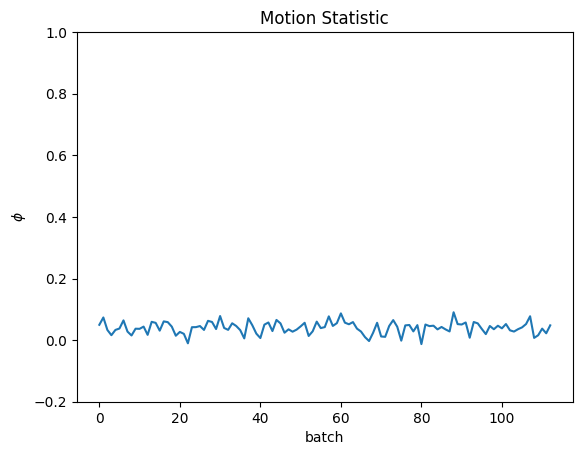

In [11]:

sampleSize=2000
result = frames.calAvgMotionStatistic(sampleSize)
graph.motionGraphByBatch(result)

# noise measurements

### QQ Plot for test Normal distribution

2024-03-28 21:03:32,343 - WARNING - only get first antenna, subCarrierIndex is 9


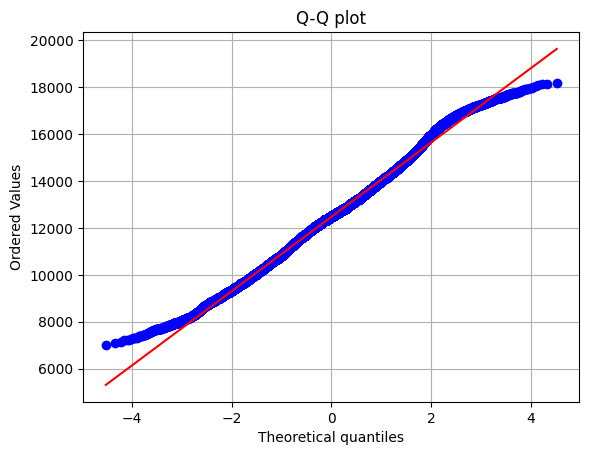

In [9]:
H_array = frames.getCSIbySubcarrier(9)
G_array = frames.computeG(H_array)
graph.QQPlot(G_array)

### compute Acf of noise

In [ ]:
# TBC...

### test subCarrier cross correlation

2024-03-28 21:03:33,031 - WARNING - only get first antenna, subCarrierIndex is 0
2024-03-28 21:03:33,107 - WARNING - only get first antenna, subCarrierIndex is 1
2024-03-28 21:03:33,181 - WARNING - only get first antenna, subCarrierIndex is 2
2024-03-28 21:03:33,255 - WARNING - only get first antenna, subCarrierIndex is 3
2024-03-28 21:03:33,327 - WARNING - only get first antenna, subCarrierIndex is 4
2024-03-28 21:03:33,401 - WARNING - only get first antenna, subCarrierIndex is 5
2024-03-28 21:03:33,473 - WARNING - only get first antenna, subCarrierIndex is 6
2024-03-28 21:03:33,546 - WARNING - only get first antenna, subCarrierIndex is 7
2024-03-28 21:03:33,618 - WARNING - only get first antenna, subCarrierIndex is 8
2024-03-28 21:03:33,690 - WARNING - only get first antenna, subCarrierIndex is 9
2024-03-28 21:03:33,762 - WARNING - only get first antenna, subCarrierIndex is 10
2024-03-28 21:03:33,835 - WARNING - only get first antenna, subCarrierIndex is 11
2024-03-28 21:03:33,908 - 

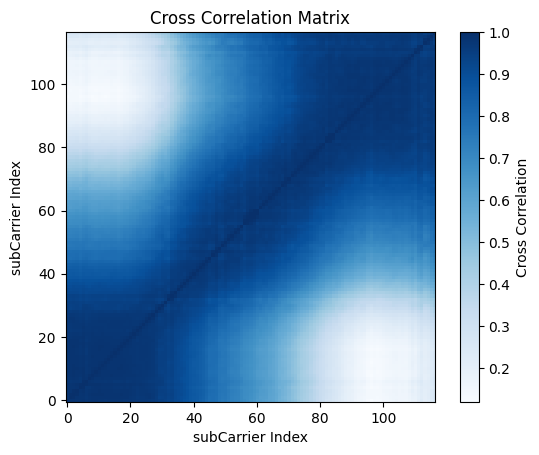

In [10]:
data = []
numTones = frames.datas[0].CSI.numTones
for i in range(numTones):
    H_of_subcarrier = frames.getCSIbySubcarrier(i)[:2000]  # 避免太大
    G_of_subcarrier = frames.computeG(H_of_subcarrier)
    data.append(G_of_subcarrier)

cross_corr_matrix = np.corrcoef(data)
graph.plotCrossCorrelation(cross_corr_matrix)